## Section1: Data Sampler

> 1.1 Mushroom

In [ ]:
#%%writefile 'scripts/data/data_sampler.py' 
import numpy as np
import pandas as pd
import tensorflow as tf


def one_hot(df, cols):
    
    """Returns one-hot encoding of DataFrame df including columns in cols."""
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(col, axis=1)
    return df

The Mushroom Dataset (Schlimmer, 1981) contains 22 attributes per mushroom, and
two classes: poisonous and safe. As in Blundell et al. (2015), we create a bandit problem where the
agent must decide whether to eat or not a given mushroom. Eating a safe mushroom provides reward
+5. Eating a poisonous mushroom delivers reward +5 with probability 1/2 and reward -35 otherwise.
If the agent does not eat a mushroom, then the reward is 0. 

In [ ]:
#%%writefile -a 'scripts/data/data_sampler.py' 
def sample_mushroom_data(file_name,
                         num_contexts,
                         r_noeat=0,
                         r_eat_safe=5,
                         r_eat_poison_bad=-35,
                         r_eat_poison_good=5,
                         prob_poison_bad=0.5):
    """Samples bandit game from Mushroom UCI Dataset.
    Args:
    file_name: Route of file containing the original Mushroom UCI dataset.
    num_contexts: Number of points to sample, i.e. (context, action rewards).
    r_noeat: Reward for not eating a mushroom.
    r_eat_safe: Reward for eating a non-poisonous mushroom.
    r_eat_poison_bad: Reward for eating a poisonous mushroom if harmed.
    r_eat_poison_good: Reward for eating a poisonous mushroom if not harmed.
    prob_poison_bad: Probability of being harmed by eating a poisonous mushroom.
    Returns:
    dataset: Sampled matrix with n rows: (context, eat_reward, no_eat_reward).
    opt_vals: Vector of expected optimal (reward, action) for each context.
    We assume r_eat_safe > r_noeat, and r_eat_poison_good > r_eat_poison_bad.
    ###########
    after one hot encoding
    first column: edibale or not
    second column: poisonious or not
    column 2: : context
    """

    # first two cols of df encode whether mushroom is edible or poisonous
    df = pd.read_csv(file_name)
    df = one_hot(df, df.columns)
    ind = np.random.choice(range(df.shape[0]), num_contexts, replace=True)

    contexts = df.iloc[ind, 2:]
    no_eat_reward = r_noeat * np.ones((num_contexts, 1))
    random_poison = np.random.choice(
      [r_eat_poison_bad, r_eat_poison_good],
      p=[prob_poison_bad, 1 - prob_poison_bad],
      size=num_contexts)
    eat_reward = r_eat_safe * df.iloc[ind, 0]
    eat_reward += np.multiply(random_poison, df.iloc[ind, 1])
    eat_reward = eat_reward.values.reshape((num_contexts, 1))

    # compute optimal expected reward and optimal actions
    exp_eat_poison_reward = r_eat_poison_bad * prob_poison_bad
    exp_eat_poison_reward += r_eat_poison_good * (1 - prob_poison_bad)
    opt_exp_reward = r_eat_safe * df.iloc[ind, 0] + max(
      r_noeat, exp_eat_poison_reward) * df.iloc[ind, 1]

    if r_noeat > exp_eat_poison_reward:
    # actions: no eat = 0 ; eat = 1
        # eat only edible mushrooms
        opt_actions = df.iloc[ind, 0]  # indicator of edible
    else:
        # should always eat (higher expected reward)
        
        opt_actions = np.ones((num_contexts, 1))

    opt_vals = (opt_exp_reward.values, opt_actions.values)

    return np.hstack((contexts.values, no_eat_reward, eat_reward)), opt_vals


> 1.2 Census

The US Census (1990) Dataset (Asuncion & Newman, 2007) contains a number of personal
features (age, native language, education...) which we summarize in d = 389 covariates, including
binary dummy variables for categorical features. Our goal again is to predict the occupation of the
individual among k = 9 classes. The agent obtains reward 1 for making the right prediction, and 0
otherwise, for each of the n = 250000 randomly selected data points.

source: https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/ (USCensus1990.data.txt)

In [ ]:
#%%writefile -a 'scripts/data/data_sampler.py' 
def sample_census_data(file_name, num_contexts, shuffle_rows=True):
    """Returns bandit problem dataset based on the UCI census data.
    Args:
    file_name: Route of file containing the Census dataset.
    num_contexts: Number of contexts to sample.
    shuffle_rows: If True, rows from original dataset are shuffled.
    remove_underrepresented: If True, removes arms with very few rewards.
    Returns:
    dataset: Sampled matrix with rows: (context, action rewards).
    opt_vals: Vector of deterministic optimal (reward, action) for each context.
    Preprocessing:
    * drop rows with missing labels
    * convert categorical variables to 1 hot encoding
    Note: this is the processed (not the 'raw') dataset. It contains a subset
    of the raw features and they've all been discretized.

    """
    # 'USCensus1990.data.txt'
    df = pd.read_csv(file_name, sep=",")

    num_actions = 9

    if shuffle_rows:
        df = df.sample(frac=1)
    df = df.iloc[:num_contexts, :]

    # Assuming what the paper calls response variable is the label?
    labels = df['dOccup'].astype('category').cat.codes.as_matrix()
    # In addition to label, also drop the (unique?) key.
    df = df.drop(['dOccup', 'caseid'], axis=1)

    # All columns are categorical. Convert to 1 hot encoding.
    df = pd.get_dummies(df, columns=df.columns)

#     if remove_underrepresented:
#         df, labels = remove_underrepresented_classes(df, labels)
    contexts = df.as_matrix()

    return classification_to_bandit_problem(contexts, labels, num_actions)

> 1.3 Adult

The Adult Dataset (Kohavi, 1996; Asuncion & Newman, 2007) comprises personal information from the US Census Bureau database, and the standard prediction task is to determine if a person
makes over $50K a year or not. However, we consider the k = 14 different occupations as feasible
actions, based on d = 94 covariates (many of them binarized). As in previous datasets, the agent
obtains reward 1 for making the right prediction, and 0 otherwise.

source: https://archive.ics.uci.edu/ml/datasets/census+income

In [ ]:
#%%writefile -a 'scripts/data/data_sampler.py' 
def sample_adult_data(file_name, num_contexts, shuffle_rows=True):
    """Returns bandit problem dataset based on the UCI adult data.
    Args:
    file_name: Route of file containing the Adult dataset.
    num_contexts: Number of contexts to sample.
    shuffle_rows: If True, rows from original dataset are shuffled.
    remove_underrepresented: If True, removes arms with very few rewards.
    Returns:
    dataset: Sampled matrix with rows: (context, action rewards).
    opt_vals: Vector of deterministic optimal (reward, action) for each context.
    Preprocessing:
    * drop rows with missing values
    * convert categorical variables to 1 hot encoding
    """
    # adult.data
    df = pd.read_csv(file_name, sep=",", header=None,
                     na_values=[' ?']).dropna()

    num_actions = 14

    if shuffle_rows:
        df = df.sample(frac=1)
    df = df.iloc[:num_contexts, :]

    labels = df[6].astype('category').cat.codes.as_matrix()
    df = df.drop([6], axis=1)

    # Convert categorical variables to 1 hot encoding
    cols_to_transform = [1, 3, 5, 7, 8, 9, 13, 14]
    df = pd.get_dummies(df, columns=cols_to_transform)

#     if remove_underrepresented:
#     df, labels = remove_underrepresented_classes(df, labels)
    contexts = df.as_matrix()

    return classification_to_bandit_problem(contexts, labels, num_actions)

## Section 2: Core codes

> 2.1 Turning classificaion to a bandit problem

In [ ]:
#%%writefile -a 'scripts/data/data_sampler.py' 

def safe_std(values):
    """Remove zero std values for ones."""
    return np.array([val if val != 0.0 else 1.0 for val in values])

def classification_to_bandit_problem(contexts, labels, num_actions=None):
    
        
    """
      Normalize contexts and encode deterministic rewards.
         returns (third output): optimal reward(always 1) and optimal actions(the labels)
    """
    
    if num_actions is None:
        num_actions = np.max(labels) + 1
    num_contexts = contexts.shape[0]

    # Due to random subsampling in small problems, some features may be constant
    sstd = safe_std(np.std(contexts, axis=0, keepdims=True)[0, :])

    # Normalize features
    contexts = ((contexts - np.mean(contexts, axis=0, keepdims=True)) / sstd)

    # One hot encode labels as rewards
    rewards = np.zeros((num_contexts, num_actions))
    rewards[np.arange(num_contexts), labels] = 1.0

    return contexts, rewards, (np.ones(num_contexts), labels)

> 2.2 Creating a ContextualBandit object on which we can define some methods to feed data

In [ ]:
#%%writefile -a 'scripts/core/contextual_bandit.py'
class ContextualBandit(object):
    """Implements a Contextual Bandit with d-dimensional contexts and k arms."""

    def __init__(self, context_dim, num_actions):
        """Creates a contextual bandit object.
        Args:
          context_dim: Dimension of the contexts.
          num_actions: Number of arms for the multi-armed bandit.
        """

        self._context_dim = context_dim
        self._num_actions = num_actions

    def feed_data(self, data):
        """Feeds the data (contexts + rewards) to the bandit object.
        Args:
          data: Numpy array with shape [n, d+k], where n is the number of contexts,
            d is the dimension of each context, and k the number of arms (rewards) ---> this is the output of sample_*_data
        Raises:
          ValueError: when data dimensions do not correspond to the object values.
        """

        if data.shape[1] != self.context_dim + self.num_actions:
            raise ValueError('Data dimensions do not match.')

        self._number_contexts = data.shape[0]
        self.data = data
        self.order = range(self.number_contexts)

    def reset(self):
        """Randomly shuffle the order of the contexts to deliver."""
        self.order = np.random.permutation(self.number_contexts)

    def context(self, number):
        """Returns the number-th context."""
        return self.data[self.order[number]][:self.context_dim]

    def reward(self, number, action):
        """Returns the reward for the number-th context and action."""
        return self.data[self.order[number]][self.context_dim + action]

    def optimal(self, number):
        """Returns the optimal action (in hindsight) for the number-th context."""
        return np.argmax(self.data[self.order[number]][self.context_dim:])

    @property
    def context_dim(self):
        return self._context_dim

    @property
    def num_actions(self):
        return self._num_actions

    @property
    def number_contexts(self):
        return self._number_contexts

> 2.3 The abstract class for contextual bandits

In [ ]:
#%%writefile 'scripts/core/bandit_algorithm.py'
class BanditAlgorithm(object):
    """A bandit algorithm must be able to do two basic operations.
    1. Choose an action given a context.
    2. Update its internal model given a triple (context, played action, reward).
    """

    def action(self, context):
        pass

    def update(self, context, action, reward):
        pass

> 2.4 The abstract class for Bayesian Neural Networks

In [ ]:
#%%writefile 'scripts/core/bayesian_nn.py' 
class BayesianNN(object):
    """A Bayesian neural network keeps a distribution over neural nets."""

    def __init__(self, optimizer):
        pass

    def build_model(self):
        pass

    def train(self, data):
        pass

    def sample(self, steps):
        pass

> 2.5 Creating ContextualDataset object on which we define some attributes and methods every algorithm needs to add data to or to query data from selected actions 

In [ ]:
#%%writefile -a 'scripts/core/contextual_dataset.py' 
class ContextualDataset(object):
    """The buffer is able to append new data, and sample random minibatches."""

    def __init__(self, context_dim, num_actions, buffer_s=-1, intercept=False):
        """Creates a ContextualDataset object.
        The data is stored in attributes: contexts and rewards.
        The sequence of taken actions are stored in attribute actions.
        Args:
          context_dim: Dimension of the contexts.
          num_actions: Number of arms for the multi-armed bandit.
          buffer_s: Size of buffer for training. Only last buffer_s will be
            returned as minibatch. If buffer_s = -1, all data will be used.
          intercept: If True, it adds a constant (1.0) dimension to each context X,
            at the end.
        """

        self._context_dim = context_dim
        self._num_actions = num_actions
        self._contexts = None
        self._rewards = None
        self.actions = []
        self.buffer_s = buffer_s
        self.intercept = intercept

    def add(self, context, action, reward):
        """Adds a new triplet (context, action, reward) to the dataset.---> online learning
        The reward for the actions that weren't played is assumed to be zero.
        Args:
          context: A d-dimensional vector with the context.
          action: Integer between 0 and k-1 representing the chosen arm.
          reward: Real number representing the reward for the (context, action).
        """

        if self.intercept:

            c = np.array(context[:])
            c = np.append(c, 1.0).reshape((1, self.context_dim + 1))
        else:
            c = np.array(context[:]).reshape((1, self.context_dim))

        if self.contexts is None:
            self.contexts = c
        else:
            self.contexts = np.vstack((self.contexts, c))

        r = np.zeros((1, self.num_actions))
        r[0, action] = reward
        if self.rewards is None:
            self.rewards = r
        else:
            self.rewards = np.vstack((self.rewards, r))

        self.actions.append(action)

    def replace_data(self, contexts=None, actions=None, rewards=None):
        if contexts is not None:
            self.contexts = contexts
        if actions is not None:
            self.actions = actions
        if rewards is not None:
            self.rewards = rewards

    def get_batch(self, batch_size):
        """Returns a random minibatch of (contexts, rewards) with batch_size."""
        n, _ = self.contexts.shape
        if self.buffer_s == -1:
          # use all the data
            ind = np.random.choice(range(n), batch_size)
        else:
          # use only buffer (last buffer_s observations)
            ind = np.random.choice(range(max(0, n - self.buffer_s), n), batch_size)
        return self.contexts[ind, :], self.rewards[ind, :]

    def get_data(self, action):
        """Returns all (context, reward) where the action was played."""
        n, _ = self.contexts.shape
        ind = np.array([i for i in range(n) if self.actions[i] == action])
        return self.contexts[ind, :], self.rewards[ind, action]

    def get_data_with_weights(self):
        """Returns all observations with one-hot weights for actions. 1 for selected actions 0 otherwise."""
        weights = np.zeros((self.contexts.shape[0], self.num_actions))
        a_ind = np.array([(i, val) for i, val in enumerate(self.actions)])
        weights[a_ind[:, 0], a_ind[:, 1]] = 1.0
        return self.contexts, self.rewards, weights

    def get_batch_with_weights(self, batch_size):
        """Returns a random mini-batch with one-hot weights for actions."""
        n, _ = self.contexts.shape
        if self.buffer_s == -1:
          # use all the data
            ind = np.random.choice(range(n), batch_size)
        else:
          # use only buffer (last buffer_s obs)
            ind = np.random.choice(range(max(0, n - self.buffer_s), n), batch_size)

        weights = np.zeros((batch_size, self.num_actions))
        sampled_actions = np.array(self.actions)[ind]
        a_ind = np.array([(i, val) for i, val in enumerate(sampled_actions)])
        weights[a_ind[:, 0], a_ind[:, 1]] = 1.0
        return self.contexts[ind, :], self.rewards[ind, :], weights

    def num_points(self, f=None):
        """Returns number of points in the buffer (after applying function f)."""
        if f is not None:
            return f(self.contexts.shape[0])
        return self.contexts.shape[0]

    @property
    def context_dim(self):
        return self._context_dim

    @property
    def num_actions(self):
        return self._num_actions

    @property
    def contexts(self):
        return self._contexts

    @contexts.setter
    def contexts(self, value):
        self._contexts = value

    @property
    def actions(self):
        return self._actions

    @actions.setter
    def actions(self, value):
        self._actions = value

    @property
    def rewards(self):
        return self._rewards

    @rewards.setter
    def rewards(self, value):
        self._rewards = value

## Section 3: Algorithms

> ### 3.1 Linear contextual bandit Thompson Sampling 

Performs Bayesian linear regression for exact posterior inference in linear models:
    
Assuming the reward $Y_a$ for each action(arm) a given context $X_t$ at round t is obtained by:
$$Y_a = {X_t}^T \beta_a + \epsilon_a $$ with $\epsilon_a \sim N(0,\sigma_a^2)$  Thus:

$$p(Y_a|\beta_a,\sigma_i^2,X_a) \sim N(X_a^T \beta_a,\sigma_a^2)$$

and according to Bayes theorem the posterior at time t for action i after observing context X_i and reward Y_i is obtained by:

$$
 \begin{aligned}
    p_t(\beta_a,\sigma_a^2|Y_i,X_i) &= p_t(\beta_a,\sigma_a^2) \times p_t(Y_a|\beta_a,\sigma_a^2,X_a)\\
    &=p_t(\beta_a|\sigma_a^2)p_t(\sigma_a^2)p_t(Y_a|\beta_a,\sigma_a^2,X_a)
 \end{aligned}
$$

where we assume $p_0(\sigma_a^2) \sim IG(a_0 ,b_0)$ and $p_0(\beta_a|\sigma_a^2) \sim N(\mu_0,\sigma_a^2 \Sigma_0)$.
Here, we take $\Sigma_0 = \sigma_0^2 \frac{1}{\lambda} Id$ and $\Lambda_0 = \lambda Id$
therefore, the above formula gives us the inference for the posterior parameters as :

$$
\begin{aligned}
\Sigma_t & = {(X_a^T X + \Lambda_0)}^{-1} \\
\mu_t &= \Sigma_t(\Lambda_0 \mu_0 + X_a^TY_a)\\
a_t &= a_0 + t/2\\
b_t &= b_0 + 1/2 (Y_a^TY_a+\mu_0^T \Sigma_0 \mu_0 - \mu_t^T \Sigma_t^{-1} \mu_t)
\end{aligned}
$$



In [ ]:
#%%writefile 'scripts/algorithms/linear_thompson_sampling.py' 
class LinTS(BanditAlgorithm):
    """Bayesian Linear Regression"""
    
    def __init__(self, name, hparams):
        """
        Args:
          name: Name of the algorithm.
          hparams: Hyper-parameters of the algorithm.
        """

        self.name = name
        self.hparams = hparams

        # Gaussian prior for each beta_i: zero mean
        self._lambda_prior = self.hparams.lambda_prior #\lambda

        self.mu = [
            np.zeros(self.hparams.context_dim + 1)
            for _ in range(self.hparams.num_actions)
        ]

        self.cov = [(1.0 / self.lambda_prior) * np.eye(self.hparams.context_dim + 1)
                    for _ in range(self.hparams.num_actions)] 

        self.precision = [
            self.lambda_prior * np.eye(self.hparams.context_dim + 1)
            for _ in range(self.hparams.num_actions)
        ] # \Lambda_0

        # Inverse Gamma prior for each sigma2_i
        self._a0 = self.hparams.a0
        self._b0 = self.hparams.b0

        self.a = [self._a0 for _ in range(self.hparams.num_actions)]
        self.b = [self._b0 for _ in range(self.hparams.num_actions)]

        self.t = 0
        self.data_h = ContextualDataset(hparams.context_dim,
                                        hparams.num_actions,
                                        intercept=True)

    def action(self, context):
        """for given context Samples beta's from posterior, and chooses action with maximum X^T \beta_i + \epsilon_i.
        Args:
          context: Context for which the action need to be chosen.
        Returns:
          action: Selected action for the context.
        """

        # Round robin until each action has been selected "initial_pulls" times
        if self.t < self.hparams.num_actions * self.hparams.initial_pulls:
            return self.t % self.hparams.num_actions

        # Sample sigma2, and beta conditional on sigma2
        sigma2_s = [
            self.b[i] * invgamma.rvs(self.a[i])
            for i in range(self.hparams.num_actions)
        ]

        try:
            beta_s = [
                np.random.multivariate_normal(self.mu[i], sigma2_s[i] * self.cov[i])
                for i in range(self.hparams.num_actions)
            ]
        except np.linalg.LinAlgError as e:
            # Sampling could fail if covariance is not positive definite
            print('Exception when sampling from {}.'.format(self.name))
            print('Details: {} | {}.'.format(e.message, e.args))
            d = self.hparams.context_dim + 1
            beta_s = [
                  np.random.multivariate_normal(np.zeros((d)), np.eye(d))
                  for i in range(self.hparams.num_actions)
              ]

        # Compute sampled expected values, intercept is last component of beta
        vals = [
            np.dot(beta_s[i][:-1], context.T) + beta_s[i][-1]
            for i in range(self.hparams.num_actions)
        ]

        return np.argmax(vals)

    def update(self, context, action, reward):
        """Updates action posterior using the linear Bayesian regression formula.
        Args:
          context: Last observed context.
          action: Last observed action.
          reward: Last observed reward.
        """

        self.t += 1
        self.data_h.add(context, action, reward)

        # Update posterior of action with formulas: \beta | x,y ~ N(mu_q, cov_q) with the observed data from that action
        x, y = self.data_h.get_data(action)

        # The algorithm could be improved with sequential update formulas (cheaper)
        s = np.dot(x.T, x)

        # Some terms are removed as we assume prior mu_0 = 0.
        precision_a = s + self.lambda_prior * np.eye(self.hparams.context_dim + 1)
        cov_a = np.linalg.inv(precision_a)
        mu_a = np.dot(cov_a, np.dot(x.T, y))

        # Inverse Gamma posterior update
        a_post = self.a0 + x.shape[0] / 2.0
        b_upd = 0.5 * (np.dot(y.T, y) - np.dot(mu_a.T, np.dot(precision_a, mu_a)))
        b_post = self.b0 + b_upd

        # Store new posterior distributions
        self.mu[action] = mu_a
        self.cov[action] = cov_a
        self.precision[action] = precision_a
        self.a[action] = a_post
        self.b[action] = b_post

    @property
    def a0(self):
        return self._a0

    @property
    def b0(self):
        return self._b0

    @property
    def lambda_prior(self):
        return self._lambda_prior

In [ ]:
#%%writefile 'scripts/algorithms/linucb.py' 
class LinUcb(BanditAlgorithm):
    def __init__(self, name, hparams):
        """
        Args:
          name: Name of the algorithm.
          hparams: Hyper-parameters of the algorithm.
        """

        self.name = name
        self.hparams = hparams

        # Gaussian prior for each beta_i: zero mean
        self._alpha = self.hparams.alpha #\lambda

        self.b = [
            np.zeros(self.hparams.context_dim)
            for _ in range(self.hparams.num_actions)
        ]

        self.Ainv = [np.eye(self.hparams.context_dim)
                    for _ in range(self.hparams.num_actions)] 

       

       
        self.data_h = ContextualDataset(hparams.context_dim,
                                        hparams.num_actions,
                                        intercept=True)
        
    def action(self, context):
        """for given context Samples beta's from posterior, and chooses action with maximum X^T \beta_i + \epsilon_i.
        Args:
          context: Context for which the action need to be chosen.
        Returns:
          action: Selected action for the context.
        """

        
        preds = [
            self.Ainv[i].dot(self.b[i]).T.dot(context)
            for i in range(self.hparams.num_actions)
        ]
        
        cbs = [
            self.alpha * np.sqrt(np.linalg.multi_dot([context.T, self.Ainv[i], context]))
            for i in range(self.hparams.num_actions)
            
        ]

        
        # Compute sampled expected values, intercept is last component of beta
        vals = [
            preds[i]+cbs[i]
            for i in range(self.hparams.num_actions)
        ]

        return np.argmax(vals)
    
    def update(self, context, action, reward):
        
        
        self.Ainv[action] -= np.linalg.multi_dot([self.Ainv[action], context.reshape(-1,1), context.reshape(-1,1).T,self.Ainv[action]]) / \
                             (1.0 + np.linalg.multi_dot([context, self.Ainv[action], context]))
        self.b[action] = self.b[action] + np.dot(context.T, reward)

        
    @property
    def alpha(self):
        return self._alpha
        

> ### 3.2: Stochastic variational  inference (bayes by back-propagation)

Bayesian inference for neural networks calculates the posterior distribution of the weights given the training data ($x,y$),
$P(w|y,x) = \frac{P(y|x,w)P(w)}{P(y|x)}$. This distribution answers predictive queries
about unseen data by taking expectations: the predictive
distribution of an unknown label $\hat{y}$ of a test data item $\hat{x}$,
is given by $P(\hat{y}|\hat{x},x,y) = E_{P(w|y,x)}[P(\hat{y}|\hat{x},w)]$
. Each possible configuration of the weights, weighted according to
the posterior distribution, makes a prediction about the unknown label given the test data item $\hat{x}$.  Thus taking an
expectation under the posterior distribution on weights is
equivalent to using an ensemble of an uncountably infinite number of neural networks. Unfortunately, this is intractable for neural networks of any practical size.

A solution to this problem is a variational approximation to the
Bayesian posterior distribution on the weights. Variational
learning finds the parameters $\theta$ of a distribution on the
weights $q(w|\theta)$ that minimises the Kullback-Leibler (KL) between this distribution and $P(w|y,x)$ as the following:

$$
\begin{aligned}
\theta^* &= argmin_\theta KL[q(w|\theta)||P(w|y,x)]\\
&=argmin_\theta \int q(w|\theta) \log \frac{q(w|\theta)}{P(y|x,w)P(w)} dw\\
&=argmin_\theta KL[q(w|\theta)||P(w)] - E_{q(w|\theta)} [\log P(y|x,w)]
\end{aligned}
$$

Suppose that the variational posterior is a diagonal Gaussian distribution, then a sample of the weights $w$ can be
obtained by sampling a unit Gaussian, shifting it by a mean
$\mu$ and scaling by a standard deviation $\sigma$.
We parameterise
the standard deviation pointwise as $\sigma = \log(1 + \exp(\rho))$
and so $\sigma$ is always non-negative. So, the variational posterior
parameters are $\theta = (\mu, \rho)$ and the transform from a sample of parameter-free noise and the variational posterior parameters that yields a posterior sample of the weights $w$ is $w=\mu+\log(1 + \exp(\rho)) \circ \epsilon$, where $\circ$ is point-wise multiplication and $\epsilon \sim N(0,I)$.

$\theta = (\mu, \rho)$ can then be obtained by minimizing the following expression (Monte Carlo estiamtion of log-liklihood plus a KL divergence term that can be calculated analytically)
as the loss function through stochastic gradient discent (mini-batches with replacement): 

$$f(w,\theta) = \sum_{i=1}^n(\log q(w|\theta) - \log P(w) - \log P(y^i|x^i,w=f(\epsilon^i,\theta)))$$ where $i$ is ampled from variationa posterior $N(\mu,\sigma^2)$

References:

https://arxiv.org/pdf/1505.05424.pdf

https://arxiv.org/pdf/1506.02557.pdf

https://arxiv.org/pdf/1802.09127.pdf

>> #### 3.2.1 First, we define the corresponding bayesian neural network:

In [ ]:
#%%writefile 'scripts/algorithms/variational_neural_bandit_model.py' 
# **some helper functions**
def log_gaussian(x, mu, sigma, reduce_sum=True):
    """Returns log Gaussian pdf."""
    res = (-0.5 * np.log(2 * np.pi) - tf.log(sigma) - tf.square(x - mu) /
         (2 * tf.square(sigma)))
    if reduce_sum:
        return tf.reduce_sum(res)
    else:
        return res

def analytic_kl(mu_1, sigma_1, mu_2, sigma_2):
    """KL for two Gaussian distributions with diagonal covariance matrix."""
    sigma_1_sq = tf.square(sigma_1)
    sigma_2_sq = tf.square(sigma_2)

    t1 = tf.square(mu_1 - mu_2) / (2. * sigma_2_sq)
    t2 = (sigma_1_sq/sigma_2_sq - 1. - tf.log(sigma_1_sq) + tf.log(sigma_2_sq))/2.
    return tf.reduce_sum(t1 + t2)

In [ ]:
#%%writefile -a 'scripts/algorithms/variational_neural_bandit_model.py' 

class VariationalNeuralBanditModel(BayesianNN):
    
    
    """Implements an approximate Bayesian NN using Variational Inference."""


    def __init__(self, hparams, name="BBBNN"):
        


        self.name = name
        self.hparams = hparams

        self.n_in = self.hparams.context_dim
        self.n_out = self.hparams.num_actions
        self.layers = self.hparams.layer_sizes
        self.init_scale = self.hparams.init_scale
        self.f_num_points = None
        if "f_num_points" in hparams:
            self.f_num_points = self.hparams.f_num_points

        self.cleared_times_trained = self.hparams.cleared_times_trained
        self.initial_training_steps = self.hparams.initial_training_steps 
        self.training_schedule = np.linspace(self.initial_training_steps,
                                             self.hparams.training_epochs,
                                             self.cleared_times_trained) # this t_s in the paper (number of mini-batches 
                                                                         # per training epoch)
        self.verbose = getattr(self.hparams, "verbose", True)

        self.weights_m = {}
        self.weights_std = {}
        self.biases_m = {}
        self.biases_std = {}

        self.times_trained = 0

        if self.hparams.use_sigma_exp_transform:            
            self.sigma_transform = tf.exp
            self.inverse_sigma_transform = np.log
        else:
            self.sigma_transform = tf.nn.softplus
            self.inverse_sigma_transform = lambda y: y + np.log(1. - np.exp(-y))

        # Whether to use the local reparameterization trick to compute the loss.
        # See details in https://arxiv.org/abs/1506.02557
        self.use_local_reparameterization = True

        self.build_graph()

    def build_mu_variable(self, shape):
        """Returns a mean variable initialized as N(0, 0.05)."""
        return tf.Variable(tf.random_normal(shape, 0.0, 0.05))

    def build_sigma_variable(self, shape, init=-5.):
        """Returns a sigma variable initialized as N(init, 0.05)."""
    # Initialize sigma to be very small initially to encourage MAP opt first
        return tf.Variable(tf.random_normal(shape, init, 0.05))

    def build_layer(self, input_x, input_x_local, shape,
                  layer_id, activation_fn=tf.nn.relu):
        """Builds a variational layer, and computes KL term.
        Args:
          input_x: Input to the variational layer.
          input_x_local: Input when the local reparameterization trick was applied.
          shape: [number_inputs, number_outputs] for the layer.
          layer_id: Number of layer in the architecture.
          activation_fn: Activation function to apply.
        Returns:
          output_h: Output of the variational layer.
          output_h_local: Output when local reparameterization trick was applied.
          neg_kl: Negative KL term for the layer.
        """

        w_mu = self.build_mu_variable(shape)
        w_sigma = self.sigma_transform(self.build_sigma_variable(shape))
        w_noise = tf.random_normal(shape)
        w = w_mu + w_sigma * w_noise

        b_mu = self.build_mu_variable([1, shape[1]]) # bias for mu
        b_sigma = self.sigma_transform(self.build_sigma_variable([1, shape[1]]))# bias for sigma
        b = b_mu

        # Store means and stds
        self.weights_m[layer_id] = w_mu
        self.weights_std[layer_id] = w_sigma
        self.biases_m[layer_id] = b_mu
        self.biases_std[layer_id] = b_sigma

        # Create outputs
        output_h = activation_fn(tf.matmul(input_x, w) + b)

        if self.use_local_reparameterization:
          # Use analytic KL divergence wrt the prior
            neg_kl = -analytic_kl(w_mu, w_sigma,
                                0., tf.to_float(np.sqrt(2./shape[0])))
        else:
              # Create empirical KL loss terms
            log_p = log_gaussian(w, 0., tf.to_float(np.sqrt(2./shape[0])))
            log_q = log_gaussian(w, tf.stop_gradient(w_mu), tf.stop_gradient(w_sigma))
            neg_kl = log_p - log_q

        # Apply local reparameterization trick: sample activations pre nonlinearity
        m_h = tf.matmul(input_x_local, w_mu) + b  # \gama_mj = \sum a_mi * mu_i,j
        v_h = tf.matmul(tf.square(input_x_local), tf.square(w_sigma)) # \delta_mj = \sum a_mi^2 * \sigma_ij^2
        output_h_local = m_h + tf.sqrt(v_h + 1e-6) * tf.random_normal(tf.shape(v_h)) # a sample from N(\gama_mj,\delta_mj)
        output_h_local = activation_fn(output_h_local)

        return output_h, output_h_local, neg_kl

    def build_action_noise(self):
        """Defines a model for additive noise per action, and its KL term."""

        # Define mean and std variables (log-normal dist) for each action.
        noise_sigma_mu = (self.build_mu_variable([1, self.n_out])
                          + self.inverse_sigma_transform(self.hparams.noise_sigma))
        noise_sigma_sigma = self.sigma_transform(
            self.build_sigma_variable([1, self.n_out]))

        pre_noise_sigma = (noise_sigma_mu
                           + tf.random_normal([1, self.n_out]) * noise_sigma_sigma)
        self.noise_sigma = self.sigma_transform(pre_noise_sigma)

        # Compute KL for additive noise sigma terms.
        if getattr(self.hparams, "infer_noise_sigma", False):
            neg_kl_term = log_gaussian(
                  pre_noise_sigma,
                  self.inverse_sigma_transform(self.hparams.noise_sigma),
                  self.hparams.prior_sigma
              )
            neg_kl_term -= log_gaussian(pre_noise_sigma,
                                          noise_sigma_mu,
                                          noise_sigma_sigma)
        else:
            neg_kl_term = 0.

        return neg_kl_term

    def build_model(self, activation_fn=tf.nn.relu):
        """Defines the actual NN model with fully connected layers.
        The loss is computed for partial feedback settings (bandits), so only
        the observed outcome is backpropagated (see weighted loss).
        Selects the optimizer and, finally, it also initializes the graph.
        Args:
          activation_fn: the activation function used in the nn layers.
        """

        if self.verbose:
            print("Initializing model {}.".format(self.name))
        neg_kl_term, l_number = 0, 0
        use_local_reparameterization = self.use_local_reparameterization

        # Compute model additive noise for each action with log-normal distribution
        neg_kl_term += self.build_action_noise()

        # Build network.
        input_x = self.x
        input_local = self.x
        n_in = self.n_in

        for l_number, n_nodes in enumerate(self.layers):
            if n_nodes > 0:
                h, h_local, neg_kl = self.build_layer(input_x, input_local,
                                                  [n_in, n_nodes], l_number)

            neg_kl_term += neg_kl
            input_x, input_local = h, h_local
            n_in = n_nodes

        # Create last linear layer
        h, h_local, neg_kl = self.build_layer(input_x, input_local,
                                              [n_in, self.n_out],
                                              l_number + 1,
                                              activation_fn=lambda x: x)
        neg_kl_term += neg_kl

        self.y_pred = h
        self.y_pred_local = h_local

        # Compute log likelihood (with learned or fixed noise level)
        if getattr(self.hparams, "infer_noise_sigma", False):
            log_likelihood = log_gaussian(
              self.y, self.y_pred_local, self.noise_sigma, reduce_sum=False)
        else:
            y_hat = self.y_pred_local if use_local_reparameterization else self.y_pred
            log_likelihood = log_gaussian(
              self.y, y_hat, self.hparams.noise_sigma, reduce_sum=False)

        # Only take into account observed outcomes (bandits setting)
        batch_size = tf.to_float(tf.shape(self.x)[0])
        weighted_log_likelihood = tf.reduce_sum(
            log_likelihood * self.weights) / batch_size

        # The objective is 1/n * (\sum_i log_like_i - KL); neg_kl_term estimates -KL
        elbo = weighted_log_likelihood + (neg_kl_term / self.n)

        self.loss = -elbo
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = tf.train.AdamOptimizer(self.hparams.initial_lr).minimize(
            self.loss, global_step=self.global_step)

        # Create tensorboard metrics
        self.create_summaries()
        self.summary_writer = tf.summary.FileWriter(
            "{}/graph_{}".format('results', self.name), self.sess.graph)

    def build_graph(self):
        """Defines graph, session, placeholders, and model.
        Placeholders are: n (size of the dataset), x and y (context and observed
        reward for each action), and weights (one-hot encoding of selected action
        for each context, i.e., only possibly non-zero element in each y).
        """

        self.graph = tf.Graph()
        with self.graph.as_default():

            self.sess = tf.Session()

            self.n = tf.placeholder(shape=[], dtype=tf.float32)

            self.x = tf.placeholder(shape=[None, self.n_in], dtype=tf.float32)
            self.y = tf.placeholder(shape=[None, self.n_out], dtype=tf.float32)
            self.weights = tf.placeholder(shape=[None, self.n_out], dtype=tf.float32)

            self.build_model()
            self.sess.run(tf.global_variables_initializer())

    def create_summaries(self):
        """Defines summaries including mean loss, and global step."""

        with self.graph.as_default():
            with tf.name_scope(self.name + "_summaries"):
                tf.summary.scalar("loss", self.loss)
                tf.summary.scalar("global_step", self.global_step)
                self.summary_op = tf.summary.merge_all()

    def assign_lr(self):
        """Resets the learning rate in dynamic schedules for subsequent trainings.
        In bandits settings, we do expand our dataset over time. Then, we need to
        re-train the network with the new data. The algorithms that do not keep
        the step constant, can reset it at the start of each *training* process.
        """

        decay_steps = 1
        if self.hparams.activate_decay:
            current_gs = self.sess.run(self.global_step)
            with self.graph.as_default():
                self.lr = tf.train.inverse_time_decay(self.hparams.initial_lr,
                                                      self.global_step - current_gs,
                                                      decay_steps,
                                                      self.hparams.lr_decay_rate)

    def train(self, data, num_steps):
        """Trains the BNN for num_steps, using the data in 'data'.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        Returns:
          losses: Loss history during training.
        """

        if self.times_trained < self.cleared_times_trained:
            num_steps = int(self.training_schedule[self.times_trained])
        self.times_trained += 1

        losses = []

        with self.graph.as_default():

            if self.verbose:
                print("Training {} for {} steps...".format(self.name, num_steps))

            for step in range(num_steps):
                x, y, weights = data.get_batch_with_weights(self.hparams.batch_size)
                _, summary, global_step, loss = self.sess.run(
                    [self.train_op, self.summary_op, self.global_step, self.loss],
                    feed_dict={
                        self.x: x,
                        self.y: y,
                        self.weights: weights,
                        self.n: data.num_points(self.f_num_points),
                    })

                losses.append(loss)

                if step % self.hparams.freq_summary == 0:
                    if self.hparams.show_training:

                        print("{} | step: {}, loss: {}".format(
                            self.name, global_step, loss))
                    self.summary_writer.add_summary(summary, global_step)

        return losses

>> #### 3.2.2 Second, we define the contextual bandit class that defines the corresponding bandit problem (the name sampling referes to Thompson sampling):

In [ ]:
#%%writefile 'scripts/algorithms/posterior_bnn_sampling.py' 
class PosteriorBNNSampling(BanditAlgorithm):
    """Posterior Sampling algorithm based on a Bayesian neural network."""

    def __init__(self, name, hparams, bnn_model='RMSProp'):
        """Creates a PosteriorBNNSampling object based on a specific optimizer.
        The algorithm has two basic tools: an Approx BNN and a Contextual Dataset.
        The Bayesian Network keeps the posterior based on the optimizer iterations.
        Args:
          name: Name of the algorithm.
          hparams: Hyper-parameters of the algorithm.
          bnn_model: Type of BNN. By default RMSProp (point estimate).
        """

        self.name = name
        self.hparams = hparams
        self.optimizer_n = hparams.optimizer

        self.training_freq = hparams.training_freq
        self.training_epochs = hparams.training_epochs
        self.t = 0
        self.data_h = ContextualDataset(hparams.context_dim, hparams.num_actions,
                                        hparams.buffer_s)

        # to be extended with more BNNs (BB alpha-div, GPs, SGFS, constSGD...)
        bnn_name = '{}-bnn'.format(name)
        if bnn_model == 'Variational':       # variational inference
            self.bnn = VariationalNeuralBanditModel(hparams, bnn_name)
#         elif bnn_model == 'AlphaDiv':
#           self.bnn = BBAlphaDivergence(hparams, bnn_name)
#         elif bnn_model == 'Variational_BF':
#           self.bnn = BfVariationalNeuralBanditModel(hparams, bnn_name)
        else:# bnn_model == 'GP':            # multi-task gaussian process
          self.bnn = MultitaskGP(hparams)
#         else:
#           self.bnn = NeuralBanditModel(self.optimizer_n, hparams, bnn_name)

    def action(self, context):
        """Selects action for context based on Thompson Sampling using the BNN."""

        if self.t < self.hparams.num_actions * self.hparams.initial_pulls:
          # round robin until each action has been taken "initial_pulls" times
            return self.t % self.hparams.num_actions

        with self.bnn.graph.as_default():
            c = context.reshape((1, self.hparams.context_dim))
            output = self.bnn.sess.run(self.bnn.y_pred, feed_dict={self.bnn.x: c})
            return np.argmax(output)

    def update(self, context, action, reward):
        """Updates data buffer, and re-trains the BNN every training_freq steps."""

        self.t += 1
        self.data_h.add(context, action, reward)

        if self.t % self.training_freq == 0:
            if self.hparams.reset_lr:
                self.bnn.assign_lr()
            self.bnn.train(self.data_h, self.training_epochs)

> ### 3.3 contextual bandits based on Bootstapped Networks

A simple empirical approach to approximate the sampling distribution of any estimator is
the Bootstrap.  The main idea is to simultaneously train $q$ models, where each model $i$
is based on a different dataset $D_i$
. When all the data $D$ is available in advance, $D_i$
is typically created
by sampling $|D|$ elements from $D$ at random **with replacement**. In our case, however, the data grows
one example at a time. Accordingly, we set a parameter $p \in (0, 1]$, and append the new datapoint to
each $D_i$ independently at random with probability $p$. So the Thompson sampling procedure in this case is:

1: among the q models select a model unifromly at random

2: take the action predicted to be best by the sampled model

3: with probability p add the new collected datapoint ($X_t,a_t,r_t$) to each q model dataset 

4: re-train all q models every update time frequency 


>> #### 3.3.1 First, we need to define a neural network structure that can be used for each of the bootstrapped samples

In [ ]:
#%%writefile 'scripts/algorithms/neural_bandit_model.py' 

class NeuralBanditModel(BayesianNN):
    """Implements a neural network for bandit problems."""

    def __init__(self, optimizer, hparams, name):
        """Saves hyper-params and builds the Tensorflow graph."""

        self.opt_name = optimizer
        self.name = name
        self.hparams = hparams
        self.verbose = getattr(self.hparams, "verbose", True)
        self.times_trained = 0
        self.build_model()

    def build_layer(self, x, num_units):
        """Builds a layer with input x; dropout and layer norm if specified."""

        init_s = self.hparams.init_scale

        layer_n = getattr(self.hparams, "layer_norm", False)
        dropout = getattr(self.hparams, "use_dropout", False)

        nn = tf.contrib.layers.fully_connected(
            x,
            num_units,
            activation_fn=self.hparams.activation,
            normalizer_fn=None if not layer_n else tf.contrib.layers.layer_norm,
            normalizer_params={},
            weights_initializer=tf.random_uniform_initializer(-init_s, init_s)
        )

        if dropout:            
            nn = tf.nn.dropout(nn, self.hparams.keep_prob)

        return nn

    def forward_pass(self):

        init_s = self.hparams.init_scale

        scope_name = "prediction_{}".format(self.name)
        with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE):
            nn = self.x
            for num_units in self.hparams.layer_sizes:
                if num_units > 0:
                    nn = self.build_layer(nn, num_units)

            y_pred = tf.layers.dense(
                      nn,
                      self.hparams.num_actions,
                      kernel_initializer=tf.random_uniform_initializer(-init_s, init_s))

        return nn, y_pred

    def build_model(self):
        """Defines the actual NN model with fully connected layers.
        The loss is computed for partial feedback settings (bandits), so only
        the observed outcome is backpropagated (see weighted loss).
        Selects the optimizer and, finally, it also initializes the graph.
        """

        # create and store the graph corresponding to the BNN instance
        self.graph = tf.Graph()

        with self.graph.as_default():
            

          # create and store a new session for the graph
            self.sess = tf.Session()


            with tf.name_scope(self.name):

                self.global_step = tf.train.get_or_create_global_step()

                # context
                self.x = tf.placeholder(
                    shape=[None, self.hparams.context_dim],
                    dtype=tf.float32,
                    name="{}_x".format(self.name))

                # reward vector
                self.y = tf.placeholder(
                    shape=[None, self.hparams.num_actions],
                    dtype=tf.float32,
                    name="{}_y".format(self.name))

                # weights (1 for selected action, 0 otherwise)
                self.weights = tf.placeholder(
                    shape=[None, self.hparams.num_actions],
                    dtype=tf.float32,
                    name="{}_w".format(self.name))

                # with tf.variable_scope("prediction_{}".format(self.name)):
                self.nn, self.y_pred = self.forward_pass()
                self.loss = tf.squared_difference(self.y_pred, self.y)
                self.weighted_loss = tf.multiply(self.weights, self.loss)
                self.cost = tf.reduce_sum(self.weighted_loss) / self.hparams.batch_size

                if self.hparams.activate_decay:
                    self.lr = tf.train.inverse_time_decay(
                      self.hparams.initial_lr, self.global_step,
                      1, self.hparams.lr_decay_rate)
                else:
                    self.lr = tf.Variable(self.hparams.initial_lr, trainable=False)

                # create tensorboard metrics
                self.create_summaries()
                self.summary_writer = tf.summary.FileWriter(
                    "{}/graph_{}".format('results', self.name), self.sess.graph)

                tvars = tf.trainable_variables()
                grads, _ = tf.clip_by_global_norm(
                    tf.gradients(self.cost, tvars), self.hparams.max_grad_norm)

                self.optimizer = self.select_optimizer()

                self.train_op = self.optimizer.apply_gradients(
                    zip(grads, tvars), global_step=self.global_step)

                self.init = tf.global_variables_initializer()

                self.initialize_graph()

    def initialize_graph(self):
        """Initializes all variables."""

        with self.graph.as_default():
            if self.verbose:
                print("Initializing model {}.".format(self.name))
            self.sess.run(self.init)

    def assign_lr(self):
        """Resets the learning rate in dynamic schedules for subsequent trainings.
        In bandits settings, we do expand our dataset over time. Then, we need to
        re-train the network with the new data. The algorithms that do not keep
        the step constant, can reset it at the start of each *training* process.
        """

        decay_steps = 1
        if self.hparams.activate_decay:
            current_gs = self.sess.run(self.global_step)
            with self.graph.as_default():
                self.lr = tf.train.inverse_time_decay(self.hparams.initial_lr,
                                                  self.global_step - current_gs,
                                                  decay_steps,
                                                  self.hparams.lr_decay_rate)

    def select_optimizer(self):        
        """Selects optimizer. To be extended (SGLD, KFAC, etc)."""
        return tf.train.RMSPropOptimizer(self.lr)

    def create_summaries(self):
        """Defines summaries including mean loss, learning rate, and global step."""

        with self.graph.as_default():
            with tf.name_scope(self.name + "_summaries"):
                tf.summary.scalar("cost", self.cost)
                tf.summary.scalar("lr", self.lr)
                tf.summary.scalar("global_step", self.global_step)
                self.summary_op = tf.summary.merge_all()

    def train(self, data, num_steps):
        """Trains the network for num_steps, using the provided data.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        """

        if self.verbose:
            print("Training {} for {} steps...".format(self.name, num_steps))

        with self.graph.as_default():

            for step in range(num_steps):
                x, y, w = data.get_batch_with_weights(self.hparams.batch_size)
                _, cost,summary, lr = self.sess.run(
                    [self.train_op, self.cost, self.summary_op, self.lr],
                    feed_dict={self.x: x, self.y: y, self.weights: w})

                if step % self.hparams.freq_summary == 0:
                    if self.hparams.show_training:
                        print("{} | step: {}, lr: {}, loss: {}".format(
                            self.name, step, lr, cost))
                    self.summary_writer.add_summary(summary, step)

            self.times_trained += 1

>> #### 3.3.2 Second, we define the bootstrapped sampler class:
    

In [ ]:
#%%writefile 'scripts/algorithms/bootstrapped_bnn_sampling.py' 
class BootstrappedBNNSampling(BanditAlgorithm):
    
    """Thompson Sampling algorithm based on training several neural networks."""

    def __init__(self, name, hparams, optimizer='RMS'):
        """Creates a BootstrappedSGDSampling object based on a specific optimizer.
          hparams.q: Number of NN models that are independently trained.(number of bootstrapped samples)
          hparams.p: Prob of independently including each selcted datapoint in each model.
        Args:
          name: Name given to the instance.
          hparams: Hyperparameters for each individual model.
          optimizer: Neural network optimization algorithm.
        """

        self.name = name
        self.hparams = hparams
        self.optimizer_n = optimizer

        self.training_freq = hparams.training_freq
        self.training_epochs = hparams.training_epochs
        self.t = 0 # keeps track of number of times update is called 

        self.q = hparams.q
        self.p = hparams.p
        
        
        # q datasets, one for each mocel
        self.datasets = [
            ContextualDataset(hparams.context_dim,
                              hparams.num_actions,
                              hparams.buffer_s)
            for _ in range(self.q)
        ]
        
        # q neural networks, one for each model
        self.bnn_boot = [
            NeuralBanditModel(optimizer, hparams, '{}-{}-bnn'.format(name, i))
            for i in range(self.q)
        ]

    def action(self, context):
        """Selects action for context based on Thompson Sampling using one BNN."""

        if self.t < self.hparams.num_actions * self.hparams.initial_pulls:
            
              # round robin until each action has been taken "initial_pulls" times
            return self.t % self.hparams.num_actions

        # choose model uniformly at random
        model_index = np.random.randint(self.q)
        # take action
        with self.bnn_boot[model_index].graph.as_default():
            c = context.reshape((1, self.hparams.context_dim))
            output = self.bnn_boot[model_index].sess.run(
                  self.bnn_boot[model_index].y_pred,
                  feed_dict={self.bnn_boot[model_index].x: c})
            return np.argmax(output)

    def update(self, context, action, reward):
        """Updates the data buffer, and re-trains the BNN every self.freq_update."""

        self.t += 1
        # add the selected action data wih proba p to each model q
        for i in range(self.q):
            
          # include the data point with probability p independently in each dataset
            if np.random.random() < self.p or self.t < 2:
                self.datasets[i].add(context, action, reward)

        if self.t % self.training_freq == 0:
          # update all the models:
            for i in range(self.q):
                if self.hparams.reset_lr:
                    self.bnn_boot[i].assign_lr()
                self.bnn_boot[i].train(self.datasets[i], self.training_epochs)

> ### 3.4 Multi-task Gaussian Process as anon-parametric method

Consider $y = f(x)+\epsilon$ where $\epsilon$ is an iid Gaussian noise with variance $\sigma_n^2$. The Gaussian process (GP)describes a joint distribution over fucntions $f(x)$. 



We have a set $X$ of $N$ distinct inputs $x1, . . . , xN$ we define the complete set of responses for $M$ tasks
as $y = (y11, . . . , yN1, . . . , y12, . . . , yN2, . . . , y1M, . . . , yNM)^T$
, where $y_{il}$ is the response for the $l$
th
task on the $i$
th input $xi$
. 

Given a set of observations $y_o$
, which is a subset of $y$, we want to predict some of the unobserved
response-values $y_u$
at some input locations for certain tasks.

We approach this problem by placing a GP prior over the latent functions ($f_l(x_i)$) so that we directly
induce correlations between tasks. Assuming that the GPs have zero mean we set

$$<f_l(x),f_k(x^\prime)> = K(x,x^\prime) = (\alpha k_{matern}(x,x^\prime) + \beta k_{lin}(x,x^\prime) ) \times K_{task}(v^k,v^l) = k^x(x,x^\prime) K^{task}$$
and $$y_{il} \sim N(f_l(x_i),\sigma_n^2)$$

So the inference for a single test point $x_*$ for task l is given by:

$$\bar{f_l}(x_*) = (k^x(x,x_*) K^{task}_l)^T (K(x,x) + \sigma_n^2 I )^{-1} y$$
and $$V[f_l(x_*)] = k^x(x_*,x_*) K^{task}_l - (k^x(x,x_*) K^{task}_l)^T (K(x,x) + \sigma_n^2 I )^{-1} (k^x(x,x_*) K^{task}_l)$$

and the objective is to maximize the log of marginal liklihood:

$$p(y|x) = \int p(y|f,x) p(f|x)$$ where under the Gaussian process model the prior is Gaussian $p(f|x) \sim N(0,K(x,x))$ or
$$log p(f|X) = −0.5 f^T K^{-1} f - 0.5 \log |K| - n/2 \log 2\pi$$, and the liklihood is $$p(y|f) \sim N(f,\sigma_n^2I)$$ As a result the log marginal liklihood becomes:
$$log(y|x) = -0.5 y^T (K+\sigma_n^2I)^{-1}y - 0.5 \log |K+\sigma_n^2I| - n/2 \log 2\pi$$

In which the parameters to optimize are $K^{task}$ elements, and the parameters of $k^x$ ($\alpha$,$\beta$, and the length scales of matern and linear kernels)

References:

* https://arxiv.org/pdf/1802.09127.pdf

* http://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf

* Gaussian Processes for Machine Learning (book)

In [ ]:
#%%writefile 'scripts/algorithms/multitask_gp.py' 
from absl import flags
FLAGS = flags.FLAGS
tfd = tf.contrib.distributions

class MultitaskGP(BayesianNN):
    """Implements a Gaussian process with multi-task outputs.
    Optimizes the hyperparameters over the log marginal likelihood.
    Uses a Matern 3/2 + linear covariance and returns
    sampled predictions for test inputs.  The outputs are optionally
    correlated where the correlation structure is learned through latent
    embeddings of the tasks.
    """

    def __init__(self, hparams):
        self.name = "MultiTaskGP"
        self.hparams = hparams

        self.n_in = self.hparams.context_dim
        self.n_out = self.hparams.num_outputs # task sim
        self.keep_fixed_after_max_obs = self.hparams.keep_fixed_after_max_obs

        self._show_training = self.hparams.show_training
        self._freq_summary = self.hparams.freq_summary

        # Dimensionality of the latent task vectors
        self.task_latent_dim = self.hparams.task_latent_dim

        # Maximum number of observations to include
        self.max_num_points = self.hparams.max_num_points

        if self.hparams.learn_embeddings:
            self.learn_embeddings = self.hparams.learn_embeddings
        else:
            self.learn_embeddings = False

        # create the graph corresponding to the BNN instance
        self.graph = tf.Graph()
        with self.graph.as_default():
            # store a new session for the graph
            self.sess = tf.Session()

            with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
                self.n = tf.placeholder(shape=[], dtype=tf.float64)
                self.x = tf.placeholder(shape=[None, self.n_in], dtype=tf.float64)
                self.x_in = tf.placeholder(shape=[None, self.n_in], dtype=tf.float64)
                self.y = tf.placeholder(shape=[None, self.n_out], dtype=tf.float64)
                self.weights = tf.placeholder(shape=[None, self.n_out],
                                              dtype=tf.float64)

                self.build_model()
            self.sess.run(tf.global_variables_initializer())

    def atleast_2d(self, x, dims):
        return tf.reshape(tf.expand_dims(x, axis=0), (-1, dims))

    def sq_dist(self, x, x2):
        a2 = tf.reduce_sum(tf.square(x), 1)
        b2 = tf.reduce_sum(tf.square(x2), 1)
        sqdists = tf.expand_dims(a2, 1) + b2 - 2.0 * tf.matmul(x, tf.transpose(x2))
        return sqdists

    # Covariance between outputs
    def task_cov(self, x, x2):
        """Squared Exponential Covariance Kernel over the latent embeding of predicted(selected) tasks."""
        # Index into latent task vectors
        x_vecs = tf.gather(self.task_vectors, tf.argmax(x, axis=1), axis=0)
        x2_vecs = tf.gather(self.task_vectors, tf.argmax(x2, axis=1), axis=0)
        r = self.sq_dist(self.atleast_2d(x_vecs, self.task_latent_dim),
                         self.atleast_2d(x2_vecs, self.task_latent_dim))
        return tf.exp(-r)

    def cov(self, x, x2):
        """Matern 3/2 + Linear Gaussian Process Covariance Function over inputs(contexts) ."""
        # alpha*marten + beta*linear
        ls = tf.clip_by_value(self.length_scales, -5.0, 5.0)
        ls_lin = tf.clip_by_value(self.length_scales_lin, -5.0, 5.0)
        r = self.sq_dist(self.atleast_2d(x, self.n_in)/tf.nn.softplus(ls),
                         self.atleast_2d(x2, self.n_in)/tf.nn.softplus(ls))
        r = tf.clip_by_value(r, 0, 1e8)

        # Matern 3/2 Covariance
        matern = (1.0 + tf.sqrt(3.0*r + 1e-16)) * tf.exp(-tf.sqrt(3.0*r + 1e-16))
        # Linear Covariance
        lin = tf.matmul(x / tf.nn.softplus(ls_lin),
                        x2 / tf.nn.softplus(ls_lin), transpose_b=True)
        return (tf.nn.softplus(self.amplitude) * matern +
                tf.nn.softplus(self.amplitude_linear) * lin)

    def build_model(self):
        """Defines the GP model.
        The loss is computed for partial feedback settings (bandits), so only
        the observed outcome is backpropagated (see weighted loss).
        Selects the optimizer and, finally, it also initializes the graph.
        """

        #logging.info("Initializing model %s.", self.name)
        self.global_step = tf.train.get_or_create_global_step()

        # Define state for the model (inputs, etc.)
        self.x_train = tf.get_variable(
            "training_data",
            initializer=tf.ones(
                [self.hparams.batch_size, self.n_in], dtype=tf.float64),
            validate_shape=False,
            trainable=False)
        self.y_train = tf.get_variable(
            "training_labels",
            initializer=tf.zeros([self.hparams.batch_size, 1], dtype=tf.float64),
            validate_shape=False,
            trainable=False)
        self.weights_train = tf.get_variable(
            "weights_train",
            initializer=tf.ones(
                [self.hparams.batch_size, self.n_out], dtype=tf.float64),
            validate_shape=False,
            trainable=False)
        self.input_op = tf.assign(self.x_train, self.x_in, validate_shape=False)
        self.input_w_op = tf.assign(
            self.weights_train, self.weights, validate_shape=False)

        self.input_std = tf.get_variable(
            "data_standard_deviation",
            initializer=tf.ones([1, self.n_out], dtype=tf.float64),
            dtype=tf.float64,
            trainable=False)
        self.input_mean = tf.get_variable(
            "data_mean",
            initializer=tf.zeros([1, self.n_out], dtype=tf.float64),
            dtype=tf.float64,
            trainable=True)

        # GP Hyperparameters
        self.noise = tf.get_variable(
            "noise", initializer=tf.cast(0.0, dtype=tf.float64))
        self.amplitude = tf.get_variable(
            "amplitude", initializer=tf.cast(1.0, dtype=tf.float64))
        self.amplitude_linear = tf.get_variable(
            "linear_amplitude", initializer=tf.cast(1.0, dtype=tf.float64))
        self.length_scales = tf.get_variable(
            "length_scales", initializer=tf.zeros([1, self.n_in], dtype=tf.float64))
        self.length_scales_lin = tf.get_variable(
            "length_scales_linear",
            initializer=tf.zeros([1, self.n_in], dtype=tf.float64))

        # Latent embeddings of the different outputs for task covariance
        self.task_vectors = tf.get_variable(
            "latent_task_vectors",
            initializer=tf.random_normal(
                [self.n_out, self.task_latent_dim], dtype=tf.float64))

        # Normalize outputs across each dimension
        # Since we have different numbers of observations across each task, we
        # normalize by their respective counts.
        index_counts = self.atleast_2d(tf.reduce_sum(self.weights, axis=0),
                                       self.n_out)
        index_counts = tf.where(index_counts > 0, index_counts,
                                tf.ones(tf.shape(index_counts), dtype=tf.float64))
        self.mean_op = tf.assign(self.input_mean,
                                 tf.reduce_sum(self.y, axis=0) / index_counts)
        self.var_op = tf.assign(
            self.input_std, tf.sqrt(1e-4 + tf.reduce_sum(tf.square(
                self.y - tf.reduce_sum(self.y, axis=0) / index_counts), axis=0)
                                    / index_counts))

        with tf.control_dependencies([self.var_op]):
            y_normed = self.atleast_2d(
              (self.y - self.input_mean) / self.input_std, self.n_out)
            y_normed = self.atleast_2d(tf.boolean_mask(y_normed, self.weights > 0), 1)
        self.out_op = tf.assign(self.y_train, y_normed, validate_shape=False)

        # Observation noise
        alpha = tf.nn.softplus(self.noise) + 1e-6

        # Covariance
        with tf.control_dependencies([self.input_op, self.input_w_op, self.out_op]):
            self.self_cov = (self.cov(self.x_in, self.x_in) *
                           self.task_cov(self.weights, self.weights) +
                           tf.eye(tf.shape(self.x_in)[0], dtype=tf.float64) * alpha)

        self.chol = tf.cholesky(self.self_cov)
        self.kinv = tf.cholesky_solve(self.chol, tf.eye(tf.shape(self.x_in)[0],
                                                        dtype=tf.float64))

        self.input_inv = tf.Variable(
            tf.eye(self.hparams.batch_size, dtype=tf.float64),
            validate_shape=False,
            trainable=False)
        self.input_cov_op = tf.assign(self.input_inv, self.kinv,
                                      validate_shape=False)

        # Log determinant by taking the singular values along the diagonal
        # of self.chol
        with tf.control_dependencies([self.input_cov_op]):
            logdet = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(self.chol) + 1e-16))

        # Log Marginal likelihood
        self.marginal_ll = -tf.reduce_sum(-0.5 * tf.matmul(
            tf.transpose(y_normed), tf.matmul(self.kinv, y_normed)) - 0.5 * logdet -
                                          0.5 * self.n * np.log(2 * np.pi))

        zero = tf.cast(0., dtype=tf.float64)
        one = tf.cast(1., dtype=tf.float64)
        standard_normal = tfd.Normal(loc=zero, scale=one)

        # Loss is marginal likelihood and priors
        self.loss = tf.reduce_sum(
            self.marginal_ll -
            (standard_normal.log_prob(self.amplitude) +
             standard_normal.log_prob(tf.exp(self.noise)) +
             standard_normal.log_prob(self.amplitude_linear) +
             tfd.Normal(loc=zero, scale=one * 10.).log_prob(
                 self.task_vectors))
        )

        # Optimizer for hyperparameters
        optimizer = tf.train.AdamOptimizer(learning_rate=self.hparams.lr)
        vars_to_optimize = [
            self.amplitude, self.length_scales, self.length_scales_lin,
            self.amplitude_linear, self.noise, self.input_mean
        ]

        if self.learn_embeddings:
            vars_to_optimize.append(self.task_vectors)
        grads = optimizer.compute_gradients(self.loss, vars_to_optimize)
        self.train_op = optimizer.apply_gradients(grads,
                                                  global_step=self.global_step)

        # Predictions for test data
        self.y_mean, self.y_pred = self.posterior_mean_and_sample(self.x)

        # create tensorboard metrics
        self.create_summaries()
        self.summary_writer = tf.summary.FileWriter("{}/graph_{}".format(
            'results', self.name), self.sess.graph)
        self.check = tf.add_check_numerics_ops()

    def posterior_mean_and_sample(self, candidates):
        """Draw samples for test predictions.
        Given a Tensor of 'candidates' inputs, returns samples from the posterior
        and the posterior mean prediction for those inputs.
        Args:
          candidates: A (num-examples x num-dims) Tensor containing the inputs for
          which to return predictions.
        Returns:
          y_mean: The posterior mean prediction given these inputs
          y_sample: A sample from the posterior of the outputs given these inputs
        """
        # Cross-covariance for test predictions
        w = tf.identity(self.weights_train)
        inds = tf.squeeze(
            tf.reshape(
                tf.tile(
                    tf.reshape(tf.range(self.n_out), (self.n_out, 1)),
                    (1, tf.shape(candidates)[0])), (-1, 1)))
        # covariances between the test points x∗ (candiates) and the training points
        cross_cov = self.cov(tf.tile(candidates, [self.n_out, 1]), self.x_train) 
        # covariance between tasks
        cross_task_cov = self.task_cov(tf.one_hot(inds, self.n_out), w)
        cross_cov *= cross_task_cov

        # Test mean prediction
        y_mean = tf.matmul(cross_cov, tf.matmul(self.input_inv, self.y_train))

        # Test sample predictions
        # Note this can be done much more efficiently using Kronecker products
        # if all tasks are fully observed (which we won't assume)
        test_cov = (
            self.cov(tf.tile(candidates, [self.n_out, 1]),
                     tf.tile(candidates, [self.n_out, 1])) *
            self.task_cov(tf.one_hot(inds, self.n_out),
                          tf.one_hot(inds, self.n_out)) -
            tf.matmul(cross_cov,
                      tf.matmul(self.input_inv,
                                tf.transpose(cross_cov))))

        # Get the matrix square root through an SVD for drawing samples
        # This seems more numerically stable than the Cholesky
        s, _, v = tf.svd(test_cov, full_matrices=True)
        test_sqrt = tf.matmul(v, tf.matmul(tf.diag(s), tf.transpose(v)))

        y_sample = (
            tf.matmul(
                test_sqrt,
                tf.random_normal([tf.shape(test_sqrt)[0], 1], dtype=tf.float64)) +
            y_mean)

        y_sample = (
            tf.transpose(tf.reshape(y_sample,
                                    (self.n_out, -1))) * self.input_std +
            self.input_mean)

        return y_mean, y_sample

    def create_summaries(self):
        with self.graph.as_default():
            tf.summary.scalar("loss", self.loss)
            tf.summary.scalar("log_noise", self.noise)
            tf.summary.scalar("log_amp", self.amplitude)
            tf.summary.scalar("log_amp_lin", self.amplitude_linear)
            tf.summary.histogram("length_scales", self.length_scales)
            tf.summary.histogram("length_scales_lin", self.length_scales_lin)
            self.summary_op = tf.summary.merge_all()

    def train(self, data, num_steps):
        """Trains the GP for num_steps, using the data in 'data'.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        """

        #logging.info("Training %s for %d steps...", self.name, num_steps)
        for step in range(num_steps):
            numpts = min(data.num_points(None), self.max_num_points)
            if numpts >= self.max_num_points and self.keep_fixed_after_max_obs:
                
                x = data.contexts[:numpts, :]
                y = data.rewards[:numpts, :]
                weights = np.zeros((x.shape[0], self.n_out))
                for i, val in enumerate(data.actions[:numpts]):
                    weights[i, val] = 1.0
            else:
                x, y, weights = data.get_batch_with_weights(numpts)

            ops = [
                  self.global_step, self.summary_op, self.loss, self.noise,
                  self.amplitude, self.amplitude_linear, self.length_scales,
                  self.length_scales_lin, self.input_cov_op, self.input_op, self.var_op,
                  self.input_w_op, self.out_op, self.train_op
              ]

            res = self.sess.run(ops,
                                  feed_dict={self.x: x,
                                             self.x_in: x,
                                             self.y: y,
                                             self.weights: weights,
                                             self.n: numpts,
                                            })

            if step % self._freq_summary == 0:
                if self._show_training:
                    logging.info("step: %d, loss: %g noise: %f amp: %f amp_lin: %f",
                               step, res[2], res[3], res[4], res[5])
            summary = res[1]
            global_step = res[0]
            self.summary_writer.add_summary(summary, global_step=global_step)

> ### functions in order to run a contextual bandit problem on a single or a set of algorithms:

In [ ]:
#%%writefile -a 'scripts/core/contextual_bandit.py' 
def run_contextual_bandit_algos(context_dim, num_actions, dataset, algos):
    """Run a contextual bandit problem on a set of algorithms.
    Args:
    context_dim: Dimension of the context.
    num_actions: Number of available actions.
    dataset: Matrix where every row is a context + num_actions rewards. ---> this is the output of sample_*_data
    algos: List of algorithms to use in the contextual bandit instance.
    Returns:
    h_actions: Matrix with actions: size (num_context, num_algorithms).
    h_rewards: Matrix with rewards: size (num_context, num_algorithms).
    """

    num_contexts = dataset.shape[0]

    # Create contextual bandit
    cmab = ContextualBandit(context_dim, num_actions)
    cmab.feed_data(dataset)

    h_actions = np.empty((0, len(algos)), float)
    h_rewards = np.empty((0, len(algos)), float)

    # Run the contextual bandit process
      # for each context:
            # select actions for each algo, get the rewards for each algo
            # update the selected action, its reward and the corresponding context for each algo
            # add  the selected actions and the given rewards to global h_actions and h_rewards
    for i in range(num_contexts):
        
        context = cmab.context(i)
        # select actions according to each algo
        actions = [a.action(context) for a in algos] # 
        rewards = [cmab.reward(i, action) for action in actions]

        for j, a in enumerate(algos):
            a.update(context, actions[j], rewards[j])

        h_actions = np.vstack((h_actions, np.array(actions)))
        h_rewards = np.vstack((h_rewards, np.array(rewards)))

    return h_actions, h_rewards

In [ ]:
#%%writefile 'scripts/core/contextual_dataset.py' 
def run_contextual_bandit(context_dim, num_actions, dataset,algo):
    """Run a contextual bandit problem on a given algorithm.
    Args:
    context_dim: Dimension of the context.
    num_actions: Number of available actions.
    dataset: Matrix where every row is a context + num_actions rewards. ---> this is the output of sample_*_data
    algos: List of algorithms to use in the contextual bandit instance.
    Returns:
    h_actions: Matrix with actions: size (num_context, num_algorithms).
    h_rewards: Matrix with rewards: size (num_context, num_algorithms).
    """

    num_contexts = dataset.shape[0]

    # Create contextual bandit
    cmab = ContextualBandit(context_dim, num_actions)
    cmab.feed_data(dataset)

    h_actions = []
    h_rewards = []

    # Run the contextual bandit process
      # for each context:
            # select actions for each algo, get the rewards for each algo
            # update the selected action, its reward and the corresponding context for each algo
            # add  the selected actions and the given rewards to global h_actions and h_rewards
    for i in range(num_contexts):
        
        context = cmab.context(i)
        # select actions according to each algo
        action = algo.action(context)# 
        reward = cmab.reward(i, action) 

        
        algo.update(context, action, reward)

        h_actions.append(action)
        h_rewards.append(reward)

    return h_actions, h_rewards

#### Test each model on mushrooms dataset:

In [ ]:
base_route = os.getcwd()
data_route = 'datasets'

In [ ]:
num_contexts = 2000
num_actions = 2
context_dim = 117
dataset, opt_mushroom = sample_mushroom_data(os.path.join(base_route, data_route, 'mushrooms.csv'), num_contexts)
opt_rewards, opt_actions = opt_mushroom

In [ ]:
dataset.shape

In [ ]:
hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
                                               context_dim=context_dim,
                                               a0=6,
                                               b0=6,
                                               lambda_prior=0.25,
                                               initial_pulls=2)

In [ ]:
algo = LinTS('LinFullPost', hparams_linear)

In [ ]:
from scipy.stats import invgamma

In [ ]:
results = run_contextual_bandit(context_dim, num_actions, dataset, algo)

In [ ]:
h_actions, h_rewards = results

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,2000),np.cumsum(h_rewards))
plt.show()

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards))

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards))

In [ ]:
hparams_ucb = tf.contrib.training.HParams(num_actions=num_actions,
                                               context_dim=context_dim,
                                               alpha=10.0)

In [ ]:
algo1 = LinUcb('LinUCB', hparams_ucb)

In [ ]:
results1 = run_contextual_bandit(context_dim, num_actions, dataset, algo1)

In [ ]:
h_actions1, h_rewards1 = results1

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(h_rewards1))
plt.show()

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards1))

In [ ]:
hparams_bbb = tf.contrib.training.HParams(num_actions=num_actions,
                                            context_dim=context_dim,
                                            init_scale=0.3,
                                            activation=tf.nn.relu,
                                            layer_sizes=[50],
                                            batch_size=512,
                                            activate_decay=True,
                                            initial_lr=0.1,
                                            max_grad_norm=5.0,
                                            show_training=False,
                                            freq_summary=1000,
                                            buffer_s=-1,
                                            initial_pulls=2,
                                            optimizer='RMS',
                                            use_sigma_exp_transform=True,
                                            cleared_times_trained=10,
                                            initial_training_steps=100,
                                            noise_sigma=0.1,
                                            reset_lr=False,
                                            training_freq=50,
                                            training_epochs=100)

In [ ]:
algo = PosteriorBNNSampling('BBB', hparams_bbb, 'Variational')

In [ ]:
results = run_contextual_bandit(context_dim, num_actions, dataset, algo)

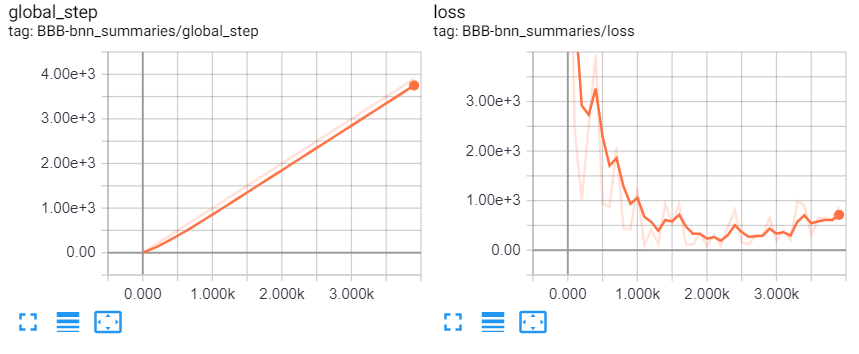

In [ ]:
h_actions2, h_rewards2 = results

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(h_rewards2))
plt.show()

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards2))

In [ ]:
hparams_gp = tf.contrib.training.HParams(num_actions=num_actions,
                                           num_outputs=num_actions,
                                           context_dim=context_dim,
                                           reset_lr=False,
                                           learn_embeddings=True,
                                           max_num_points=1000,
                                           show_training=False,
                                           freq_summary=1000,
                                           batch_size=512,
                                           keep_fixed_after_max_obs=True,
                                           training_freq=50,
                                           initial_pulls=2,
                                           training_epochs=100,
                                           lr=0.01,
                                           buffer_s=-1,
                                           initial_lr=0.001,
                                           lr_decay_rate=0.0,
                                           optimizer='RMS',
                                           task_latent_dim=5,
                                           activate_decay=False)

In [ ]:
algo = PosteriorBNNSampling('MultitaskGP', hparams_gp, 'GP')

In [ ]:
results3 = run_contextual_bandit(context_dim, num_actions, dataset, algo)

In [ ]:
h_actions3, h_rewards3 = results3

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(h_rewards3))
plt.show()

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards3))

In [ ]:
 hparams_rms = tf.contrib.training.HParams(num_actions=num_actions,
                                            context_dim=context_dim,
                                            init_scale=0.3,
                                            activation=tf.nn.relu,
                                            layer_sizes=[50],
                                            batch_size=512,
                                            activate_decay=True,
                                            initial_lr=0.1,
                                            max_grad_norm=5.0,
                                            show_training=False,
                                            freq_summary=1000,
                                            buffer_s=-1,
                                            initial_pulls=2,
                                            optimizer='RMS',
                                            reset_lr=True,
                                            lr_decay_rate=0.5,
                                            training_freq=50,
                                            training_epochs=100,
                                            p=0.95,
                                            q=3)

In [ ]:
algo = BootstrappedBNNSampling('BootRMS', hparams_rms)

In [ ]:
results4 = run_contextual_bandit(context_dim, num_actions, dataset, algo)

In [ ]:
h_actions4, h_rewards4 = results4

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(h_rewards4))
plt.show()

In [ ]:
plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards4))
plt.show()

#### Test all models on mushroom, adult, and census datasets

In [ ]:
num_actions = 14
num_contexts = 2000
sampled_vals = sample_adult_data(os.path.join(base_route, data_route, 'adult.data'), num_contexts,
                                     shuffle_rows=True)
contexts, rewards, (opt_rewards, opt_actions) = sampled_vals
dataset = np.hstack((contexts, rewards))
context_dim = contexts.shape[1]

In [ ]:
import seaborn as sns
sns.set(font_scale=2.5, style = 'whitegrid')

In [ ]:
hparams_ucb = tf.contrib.training.HParams(num_actions=num_actions,
                                               context_dim=context_dim,
                                               alpha=10.0)
hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
                                               context_dim=context_dim,
                                               a0=6,
                                               b0=6,
                                               lambda_prior=0.25,
                                               initial_pulls=2)
hparams_bbb = tf.contrib.training.HParams(num_actions=num_actions,
                                            context_dim=context_dim,
                                            init_scale=0.3,
                                            activation=tf.nn.relu,
                                            layer_sizes=[50],
                                            batch_size=512,
                                            activate_decay=True,
                                            initial_lr=0.1,
                                            max_grad_norm=5.0,
                                            show_training=False,
                                            freq_summary=1000,
                                            buffer_s=-1,
                                            initial_pulls=2,
                                            optimizer='RMS',
                                            use_sigma_exp_transform=True,
                                            cleared_times_trained=10,
                                            initial_training_steps=100,
                                            noise_sigma=0.1,
                                            reset_lr=False,
                                            training_freq=50,
                                            training_epochs=100)
hparams_gp = tf.contrib.training.HParams(num_actions=num_actions,
                                           num_outputs=num_actions,
                                           context_dim=context_dim,
                                           reset_lr=False,
                                           learn_embeddings=True,
                                           max_num_points=1000,
                                           show_training=False,
                                           freq_summary=1000,
                                           batch_size=512,
                                           keep_fixed_after_max_obs=True,
                                           training_freq=50,
                                           initial_pulls=2,
                                           training_epochs=100,
                                           lr=0.01,
                                           buffer_s=-1,
                                           initial_lr=0.001,
                                           lr_decay_rate=0.0,
                                           optimizer='RMS',
                                           task_latent_dim=5,
                                           activate_decay=False)
hparams_rms = tf.contrib.training.HParams(num_actions=num_actions,
                                            context_dim=context_dim,
                                            init_scale=0.3,
                                            activation=tf.nn.relu,
                                            layer_sizes=[50],
                                            batch_size=512,
                                            activate_decay=True,
                                            initial_lr=0.1,
                                            max_grad_norm=5.0,
                                            show_training=False,
                                            freq_summary=1000,
                                            buffer_s=-1,
                                            initial_pulls=2,
                                            optimizer='RMS',
                                            reset_lr=True,
                                            lr_decay_rate=0.5,
                                            training_freq=50,
                                            training_epochs=100,
                                            p=0.95,
                                            q=3)


In [ ]:
algos = [
      LinUcb('LinUCB', hparams_ucb),
      PosteriorBNNSampling('BBB', hparams_bbb, 'Variational'),
      LinTS('LinFullPost', hparams_linear),
      BootstrappedBNNSampling('BootRMS', hparams_rms),
      PosteriorBNNSampling('MultitaskGP', hparams_gp, 'GP'),
      
  ]

In [ ]:
results = run_contextual_bandit_algos(context_dim, num_actions, dataset, algos)

In [ ]:
 _, h_rewards = results

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    ax.plot(np.arange(0,2000),np.cumsum(h_rewards[:,i]),label= a.name)
plt.legend(loc= 'best')
plt.xlabel('rounds')
plt.ylabel('cumulative reward - adult data')
#plt.ylim((0,2000))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    ax.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards[:,i]),label= a.name)
plt.legend(loc= 'best')
plt.xlabel('rounds')
plt.ylabel('cumulative regret - adult data')
plt.show()

In [ ]:
num_actions = 9
num_contexts = 2000
sampled_vals = sample_census_data(os.path.join(base_route, data_route, 'USCensus1990.data.txt'), num_contexts,
                                      shuffle_rows=True)
contexts, rewards, (opt_rewards, opt_actions) = sampled_vals
dataset = np.hstack((contexts, rewards))
context_dim = contexts.shape[1]

In [ ]:
algos = [
      LinUcb('LinUCB', hparams_ucb),
      PosteriorBNNSampling('BBB', hparams_bbb, 'Variational'),
      BootstrappedBNNSampling('BootRMS', hparams_rms),
      PosteriorBNNSampling('MultitaskGP', hparams_gp, 'GP')
      
  ]

In [ ]:
results2 = run_contextual_bandit_algos(context_dim, num_actions, dataset, algos)

In [ ]:
 _, h_rewards2 = results2

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    ax.plot(np.arange(0,2000),np.cumsum(h_rewards2[:,i]),label= a.name)
plt.legend(loc= 'best')
plt.xlabel('rounds')
plt.ylabel('cumulative reward - census data')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    ax.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards2[:,i]),label= a.name)
plt.legend(loc= 'best')
plt.xlabel('rounds')
plt.ylabel('cumulative regret - census data')
plt.show()

In [ ]:
num_contexts = 2000
num_actions = 2
context_dim = 117
dataset, opt_mushroom = sample_mushroom_data('mushrooms.csv', num_contexts)
opt_rewards, opt_actions = opt_mushroom

In [ ]:
results3 = run_contextual_bandit_algos(context_dim, num_actions, dataset, algos)

In [ ]:
_, h_rewards3 = results3

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    ax.plot(np.arange(0,2000),np.cumsum(h_rewards3[:,i]),label= a.name)
ax.legend(loc= 'best')
ax.set_xlabel('rounds')
ax.set_ylabel('cumulative reward - mushrooms data')

plt.xlim((0,2000))
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
for i, a in enumerate(algos):
    plt.plot(np.arange(0,2000),np.cumsum(opt_rewards - h_rewards3[:,i]),label= a.name)
plt.legend(loc= 'upper left')
plt.xlabel('rounds')
plt.ylabel('cumulative regret - mushrooms data')
plt.xlim((0,2000))
plt.show()